In [1]:
# importing all the required libraries
%matplotlib inline
import cv2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from skimage.transform import rotate, AffineTransform, warp
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage.measure as measure
import random
from skimage.measure import label

In [2]:
img = cv2.imread('original_operators.png')
plus = img[:,0:310]
equal = img[:,340:650]
minus = img[:,710:1020]
divide = img[:,1080:1390]
multiply = img[:,1440:1750]

In [127]:
def color2bin(im):
    (_, im_bw) = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)
    im_bw = 255 - im_bw
    plt.imshow(im_bw, cmap= 'gray')
    return im_bw
def operators_augmentation(im, rot_step):
    out_ims =  np.array([]).reshape(0, im.shape[0], im.shape[1])
    for rot in np.arange(0, 180 + rot_step, rot_step):
        s =  random.uniform(0.99, 1.01)
        tform = AffineTransform(scale=(s, s))
        im = warp(im, tform.inverse, output_shape=im.shape)
        rotated = np.expand_dims(rotate(im, angle=rot, mode = 'constant',cval = 0),0)
        rotated[rotated>0.5] = 1
        rotated[rotated<0.5] = 0

        out_ims = np.concatenate((out_ims, rotated),0)
    return out_ims


(316, 310)


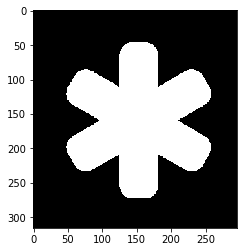

In [4]:
plus_bw = color2bin(plus)
minus_bw = color2bin(minus)
equal_bw = color2bin(equal)
divide_bw = color2bin(divide)
multiply_bw = color2bin(multiply)

padding = np.zeros((multiply_bw.shape[0],  minus_bw.shape[1] - multiply_bw.shape[1]))
multiply_bw = np.concatenate((multiply_bw, padding), 1)

print(multiply_bw.shape)

In [130]:
# rotation augmentation
rot_step = 10
plus_aug = operators_augmentation(plus_bw, rot_step)
equal_aug = operators_augmentation(equal_bw, rot_step)
divide_aug = operators_augmentation(divide_bw, rot_step)
multiply_aug = operators_augmentation(multiply_bw, rot_step)
minus_aug = operators_augmentation(minus_bw, rot_step)


### Classification

In [131]:
# Convert contour into complex signals for fourier descriptor calculations
def convert_signal(contour):
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    contour_out = []
    for im in images: 
        im = ndimage.binary_fill_holes(im) 
        im[im>0] = 255
        contours = measure.find_contours(im, 0)
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)

def get_fourier_descriptor(ims, contours, N, f1, f2, f_div):
    batch_size = ims.shape[0]//N
    batch = -1
    FD = np.zeros((N, batch_size,2))
    for ct in range(ims.shape[0]):
        if ct % batch_size == 0:
            batch += 1
        fft = np.fft.fft(contours[ct])
        # normalization
        if f_div == -1:
            FD[batch, ct % batch_size, :]  = np.abs([fft[f1],fft[f2]])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances

        else:
            FD[batch, ct % batch_size, :]  = np.abs([fft[f1],fft[f2]])/np.abs(fft[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    return FD

# Plot images with contours
def plotImagContour(axes, ims, contours):
    N = ims.shape[0]//axes.shape[0]
    ct =  0
    ax_id = 0
    if len(axes.shape) > 1:
        while ax_id < axes.shape[0]:
            for ax in axes[ax_id]:
                ax.imshow(ims[ct])
                ax.step(np.real(contours[ct]), np.imag(contours[ct]), linewidth=2, c='r')
                ax.axis('off')
                ct += 1
                if ct % N == 0:
                    ax_id += 1
    else: 
        for ax in axes:
            ax.imshow(ims[ct])
            ax.step(np.real(contours[ct]), np.imag(contours[ct]), linewidth=2, c='r')
            ax.axis('off')
            ct += 1

In [132]:
contourf_p = contour_fourier(plus_aug)
contourf_m = contour_fourier(minus_aug)
contourf_mul = contour_fourier(multiply_aug)
contourf_d = contour_fourier(divide_aug)
contourf_e = contour_fourier(equal_aug)


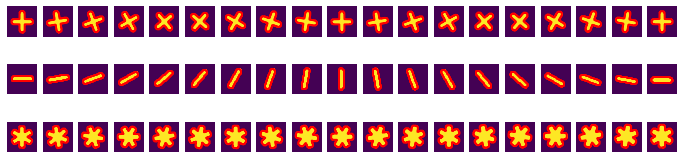

In [133]:
# Plots
im_set = np.concatenate((plus_aug, minus_aug, multiply_aug),0)
contour_set = np.concatenate((contourf_p, contourf_m, contourf_mul),0)
fig, axes = plt.subplots(im_set.shape[0]//len(plus_aug), len(plus_aug), figsize=(12, 3))

plotImagContour(axes, im_set, contour_set)



In [134]:
# fourier descriptors
f1 = 3
f2 = 5
f_div = 1
FD = get_fourier_descriptor(im_set, contour_set,  im_set.shape[0]//len(plus_aug), f1, f2, f_div)

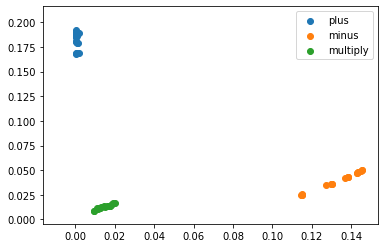

In [135]:
for i in range(im_set.shape[0]//len(plus_aug)):
    plt.scatter(FD[i, :, 0], FD[i, :, 1])
plt.legend(['plus', 'minus', 'multiply'])

In [11]:
labeled_array, num_features = ndimage.label(equal_aug[9])
print(num_features)
print((labeled_array==2).sum())
labeled_array, num_features = ndimage.label(divide_aug[1])
print(num_features)
print((labeled_array==2).sum())

2
14345
3
11098


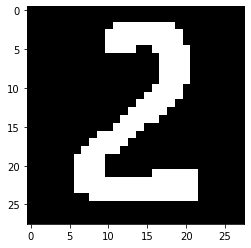

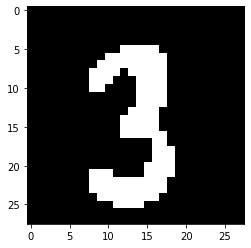

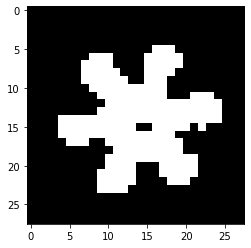

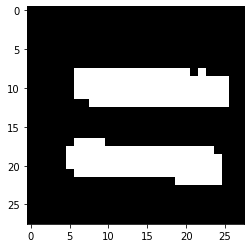

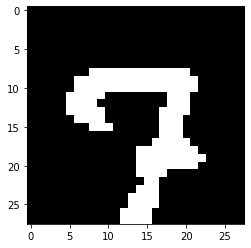

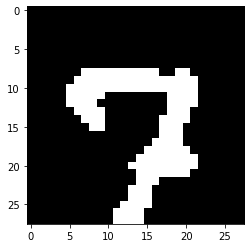

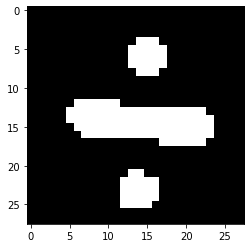

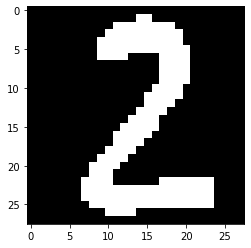

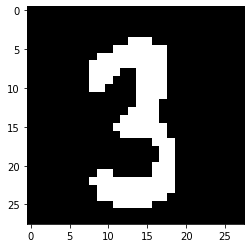

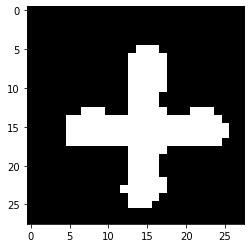

In [27]:
objects = np.load('objects.npy')
# plot images to check
for im in objects:
    plt.imshow(im, cmap = 'gray')
    plt.show()

In [136]:
one_label = []
for id, im in enumerate(objects):
    labeled_array, num_features = ndimage.label(im)
    if num_features > 3: # noise in data
        for i in range(1, num_features + 1):
            size = (labeled_array == i).sum()
            if size < 10: # threshold for noise
                print("size = ", size)
                num_features -= 1
    if num_features == 1:
        one_label.append(id)
    elif num_features == 2:
        print('id ', id, ' is equal sign')
    else:
        print('id ', id, ' is divide sign')



id  3  is equal sign
id  6  is divide sign


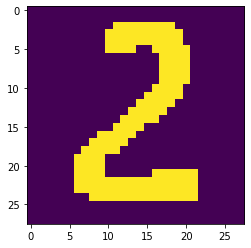

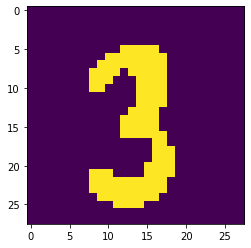

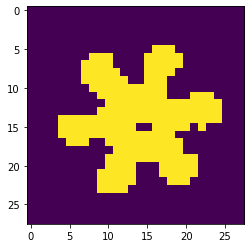

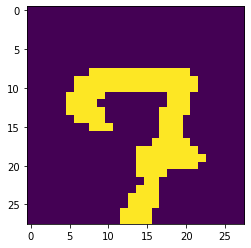

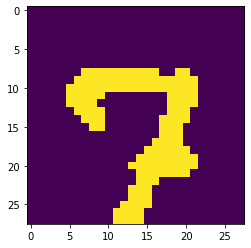

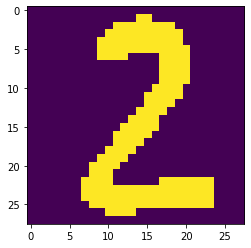

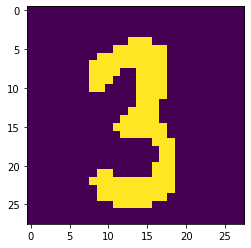

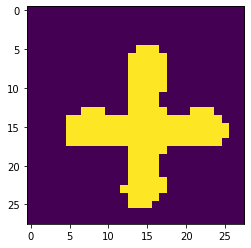

In [137]:
objects_1 = objects[one_label]
for im in objects_1:
    plt.imshow(im)
    plt.show()

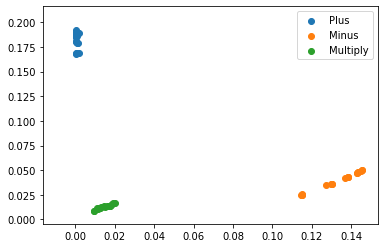

In [196]:
contourf_p = contour_fourier(plus_aug)
contourf_m = contour_fourier(minus_aug)
contourf_mul = contour_fourier(multiply_aug)
contourf_d = contour_fourier(divide_aug)
contourf_e = contour_fourier(equal_aug)

# Plots
im_set = np.concatenate((plus_aug, minus_aug, multiply_aug),0)
contour_set = np.concatenate((contourf_p, contourf_m, contourf_mul),0)
# fig, axes = plt.subplots(im_set.shape[0]//len(plus_aug), len(plus_aug), figsize=(12, 3))
# plotImagContour(axes, im_set, contour_set)

# fourier descriptors
f1 = 3
f2 = 5
f_div = 1
FD = get_fourier_descriptor(im_set, contour_set,  im_set.shape[0]//len(plus_aug), f1, f2, f_div)

for i in range(im_set.shape[0]//len(plus_aug)):
    plt.scatter(FD[i, :, 0], FD[i, :, 1])
plt.legend(['Plus', 'Minus', 'Multiply'])
plt.show()

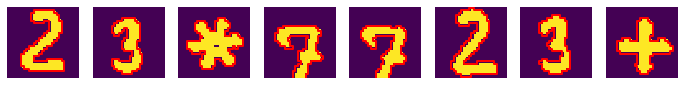

In [139]:
contourf_obj = contour_fourier(objects_1)
fig, axes = plt.subplots(objects_1.shape[0]//len(objects_1), len(objects_1), figsize=(12, 3))
plotImagContour(axes, objects_1, contourf_obj)

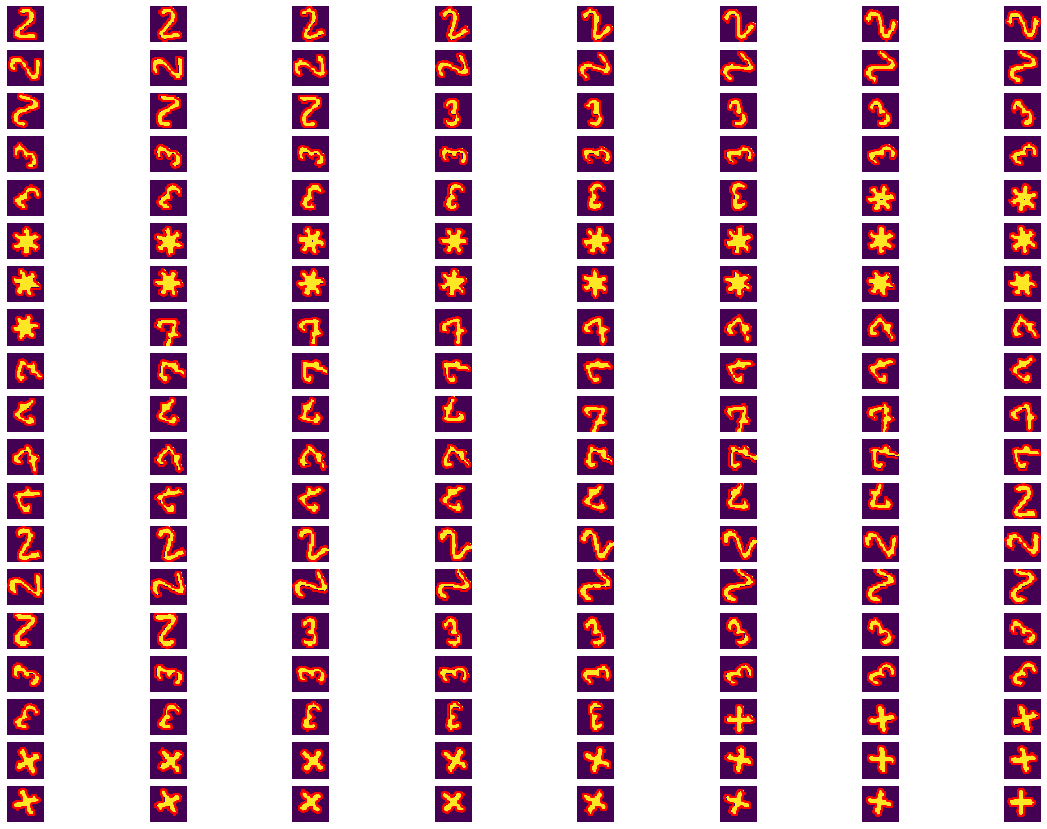

In [189]:
rot_step = 10
obj_set = operators_augmentation(objects_1[0], rot_step)
for i in range(1, objects_1.shape[0]):
    obj_set = np.concatenate((obj_set, operators_augmentation(objects_1[i], rot_step)),0)
    
contourf_obj_set = contour_fourier(obj_set)

fig, axes = plt.subplots(obj_set.shape[0]//len(objects_1), len(objects_1), figsize=(20, 15))
plotImagContour(axes, obj_set, contourf_obj_set)


In [190]:
f1 = 3
f2 = 5
f_div = 1
FD_obj = get_fourier_descriptor(obj_set, contourf_obj_set,  len(objects_1), f1, f2, f_div)


In [191]:
# plt.imshow(obj_set[0])
# plt.show()
# plt.imshow(obj_set[18])
print(obj_set.shape)
print(FD_obj.shape)


(152, 28, 28)
(8, 19, 2)


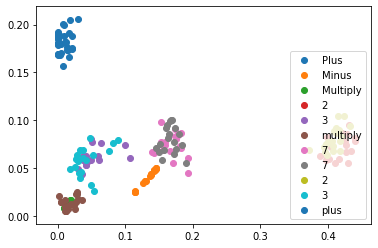

In [195]:
for i in range(im_set.shape[0]//len(plus_aug)):
    plt.scatter(FD[i, :, 0], FD[i, :, 1])

for j in range(FD_obj.shape[0]):
    plt.scatter(FD_obj[j,:,0], FD_obj[j,:,1])
plt.legend(['Plus', 'Minus', 'Multiply', '2', '3', 'multiply', '7', '7', '2', '3', 'plus'], loc = 4)
